### CREDIT

This notebook is prepared by the guidance of Jesús Martínez's book, which is Tensorflow 2.0 Computer Vision Cookbook. Most of the code blocks and explanations are taken from this book. You can reach original codes and detailed explanations from book or from github repo of the book (https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook).


#### WHAT IS THIS NOTEBOOK

This notebook is an example about conditional adversarial network known as Pix2Pix by keras and TF on cityscapes dataset.

You can check book for details (Chapter 6, recipe-3)

#### Keywords

* Pix2Pix
* image-to-image translation
* GAN
* TF
* cityscapes dataset

In [1]:
import pathlib

import cv2
import numpy as np
import tensorflow as tf
import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
NEAREST_NEIGHBOR = tf.image.ResizeMethod.NEAREST_NEIGHBOR
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [3]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    width = tf.shape(image)[1]
    width = width // 2

    real_image = image[:, :width, :]
    input_image = image[:, width:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [4]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image,
                                  size=(height, width),
                                  method=NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image,
                                 size=(height, width),
                                 method=NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    size = (2, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    cropped_image = tf.image.random_crop(stacked_image,
                                         size=size)

    input_image = cropped_image[0]
    real_image = cropped_image[1]

    return input_image, real_image


def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [5]:
@tf.function
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image,
                                     width=286, height=286)

    input_image, real_image = random_crop(input_image,
                                          real_image)

    if np.random.uniform() > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [6]:
def load_training_image(image_path):
    input_image, real_image = load_image(image_path)
    input_image, real_image = \
        random_jitter(input_image, real_image)

    input_image, real_image = \
        normalize(input_image, real_image)

    return input_image, real_image

In [13]:
def load_test_image(image_path):
    input_image, real_image = load_image(image_path)
    input_image, real_image = resize(input_image, real_image,
                                     width=IMAGE_WIDTH,
                                     height=IMAGE_HEIGHT)
    input_image, real_image = \
        normalize(input_image, real_image)

    return input_image, real_image

In [7]:
def generate_and_save_images(model, input, target, epoch):
    prediction = model(input, training=True)

    display_list = [input[0], target[0], prediction[0]]

    image = np.hstack(display_list)
    image *= 0.5
    image += 0.5
    image *= 255.0
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'{epoch + 1}.jpg', image)

In [8]:
class Pix2Pix(object):
    def __init__(self, output_channels=3, lambda_value=100):
        self.loss = BinaryCrossentropy(from_logits=True)
        self.output_channels = output_channels
        self._lambda = lambda_value

        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()

        self.gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
        self.dis_opt = Adam(learning_rate=2e-4, beta_1=0.5)

    @staticmethod
    def downsample(filters, size, batch_norm=True):
        initializer = tf.random_normal_initializer(0.0, 0.02)

        layers = Sequential()
        layers.add(Conv2D(filters=filters,
                          kernel_size=size,
                          strides=2,
                          padding='same',
                          kernel_initializer=initializer,
                          use_bias=False))

        if batch_norm:
            layers.add(BatchNormalization())

        layers.add(LeakyReLU())

        return layers

    @staticmethod
    def upsample(filters, size, dropout=False):
        init = tf.random_normal_initializer(0.0, 0.02)

        layers = Sequential()
        layers.add(Conv2DTranspose(filters=filters,
                                   kernel_size=size,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer=init,
                                   use_bias=False))

        layers.add(BatchNormalization())

        if dropout:
            layers.add(Dropout(rate=0.5))

        layers.add(ReLU())

        return layers

    def create_generator(self, input_shape=(256, 256, 3)):
        down_stack = [self.downsample(64, 4, batch_norm=False)]
        for filters in (128, 256, 512, 512, 512, 512, 512):
            down_block = self.downsample(filters, 4)
            down_stack.append(down_block)

        up_stack = []
        for _ in range(3):
            up_block = self.upsample(512, 4, dropout=True)
            up_stack.append(up_block)

        for filters in (512, 256, 128, 64):
            up_block = self.upsample(filters, 4)
            up_stack.append(up_block)

        inputs = Input(shape=input_shape)
        x = inputs

        skip_layers = []
        for down in down_stack:
            x = down(x)
            skip_layers.append(x)

        skip_layers = reversed(skip_layers[:-1])

        for up, skip_connection in zip(up_stack, skip_layers):
            x = up(x)
            x = Concatenate()([x, skip_connection])

        init = tf.random_normal_initializer(0.0, 0.02)
        output = Conv2DTranspose(
            filters=self.output_channels,
            kernel_size=4,
            strides=2,
            padding='same',
            kernel_initializer=init,
            activation='tanh')(x)

        return Model(inputs, outputs=output)

    def generator_loss(self,
                       discriminator_generated_output,
                       generator_output,
                       target):
        gan_loss = self.loss(
            tf.ones_like(discriminator_generated_output),
            discriminator_generated_output)

        # MAE
        error = target - generator_output
        l1_loss = tf.reduce_mean(tf.abs(error))
        total_gen_loss = gan_loss + (self._lambda * l1_loss)

        return total_gen_loss, gan_loss, l1_loss

    def create_discriminator(self):
        input = Input(shape=(256, 256, 3))
        target = Input(shape=(256, 256, 3))

        x = Concatenate()([input, target])

        x = self.downsample(64, 4, False)(x)
        x = self.downsample(128, 4)(x)
        x = self.downsample(256, 4)(x)

        x = ZeroPadding2D()(x)

        init = tf.random_normal_initializer(0.0, 0.02)
        x = Conv2D(filters=512,
                   kernel_size=4,
                   strides=1,
                   kernel_initializer=init,
                   use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = ZeroPadding2D()(x)
        output = Conv2D(filters=1,
                        kernel_size=4,
                        strides=1,
                        kernel_initializer=init)(x)

        return Model(inputs=[input, target], outputs=output)

    def discriminator_loss(self,
                           discriminator_real_output,
                           discriminator_generated_output):
        real_loss = self.loss(
            tf.ones_like(discriminator_real_output),
            discriminator_real_output)

        fake_loss = self.loss(
            tf.zeros_like(discriminator_generated_output),
            discriminator_generated_output)

        return real_loss + fake_loss

    @tf.function
    def train_step(self, input_image, target):
        with tf.GradientTape() as gen_tape, \
                tf.GradientTape() as dis_tape:
            gen_output = self.generator(input_image,
                                        training=True)

            dis_real_output = self.discriminator(
                [input_image, target], training=True)
            dis_gen_output = self.discriminator(
                [input_image, gen_output], training=True)

            (gen_total_loss, gen_gan_loss, gen_l1_loss) = \
                self.generator_loss(dis_gen_output,
                                    gen_output,
                                    target)
            dis_loss = \
                self.discriminator_loss(dis_real_output,
                                        dis_gen_output)

        gen_grads = gen_tape. \
            gradient(gen_total_loss,
                     self.generator.trainable_variables)
        dis_grads = dis_tape. \
            gradient(dis_loss,
                     self.discriminator.trainable_variables)

        opt_args = zip(gen_grads,
                       self.generator.trainable_variables)
        self.gen_opt.apply_gradients(opt_args)

        opt_args = zip(dis_grads,
                       self.discriminator.trainable_variables)
        self.dis_opt.apply_gradients(opt_args)

    def fit(self, train, epochs, test):
        for epoch in tqdm.tqdm(range(epochs)):
            for example_input, example_target in test.take(1):
                generate_and_save_images(self.generator,
                                         example_input,
                                         example_target,
                                         epoch)

            for input_image, target in train:
                self.train_step(input_image, target)

In [9]:
dataset_path = (pathlib.Path.home() / '.keras' / 'datasets' /
                'cityscapes')
train_dataset_pattern = str(dataset_path / 'train' / '*.jpg')
test_dataset_pattern = str(dataset_path / 'val' / '*.jpg')

In [10]:
train_dataset_pattern

'C:\\Users\\Zeki\\.keras\\datasets\\cityscapes\\train\\*.jpg'

In [11]:
BUFFER_SIZE = 400
BATCH_SIZE = 1

In [14]:
train_ds = (tf.data.Dataset
            .list_files(train_dataset_pattern)
            .map(load_training_image,
                 num_parallel_calls=AUTOTUNE)
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE))
test_ds = (tf.data.Dataset
           .list_files(test_dataset_pattern)
           .map(load_test_image)
           .batch(BATCH_SIZE))


In [15]:
pix2pix = Pix2Pix()
pix2pix.fit(train_ds, epochs=150, test=test_ds)

  1%|          | 1/150 [07:25<18:27:14, 445.87s/it]


KeyboardInterrupt: 

##### !!! INTERRUPTED by me, time_consuming and  high temp on GPU

Even 2 epochs, we can see the improvemnet of model..

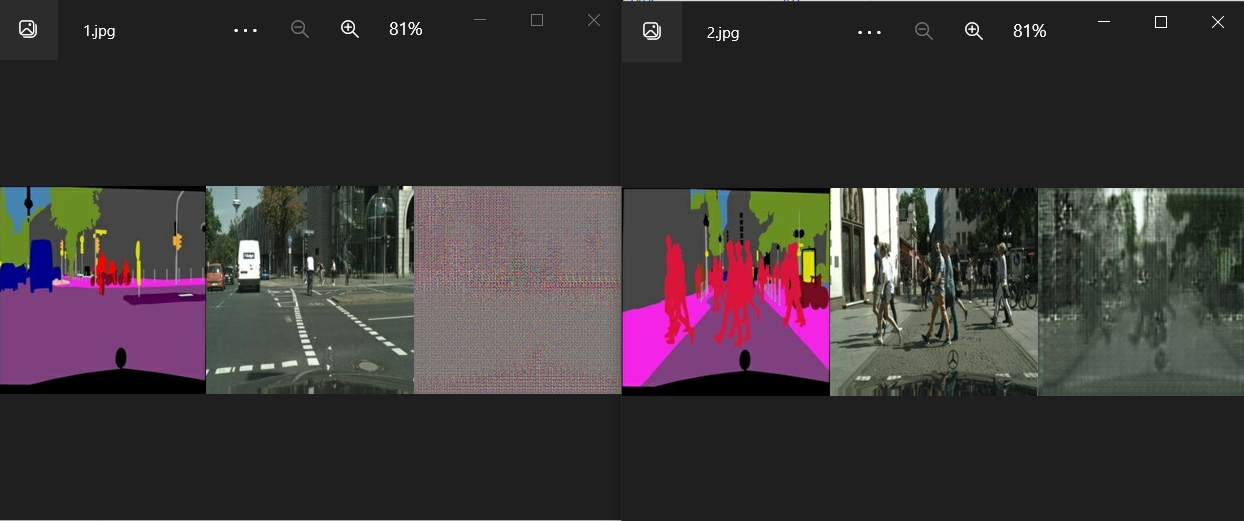

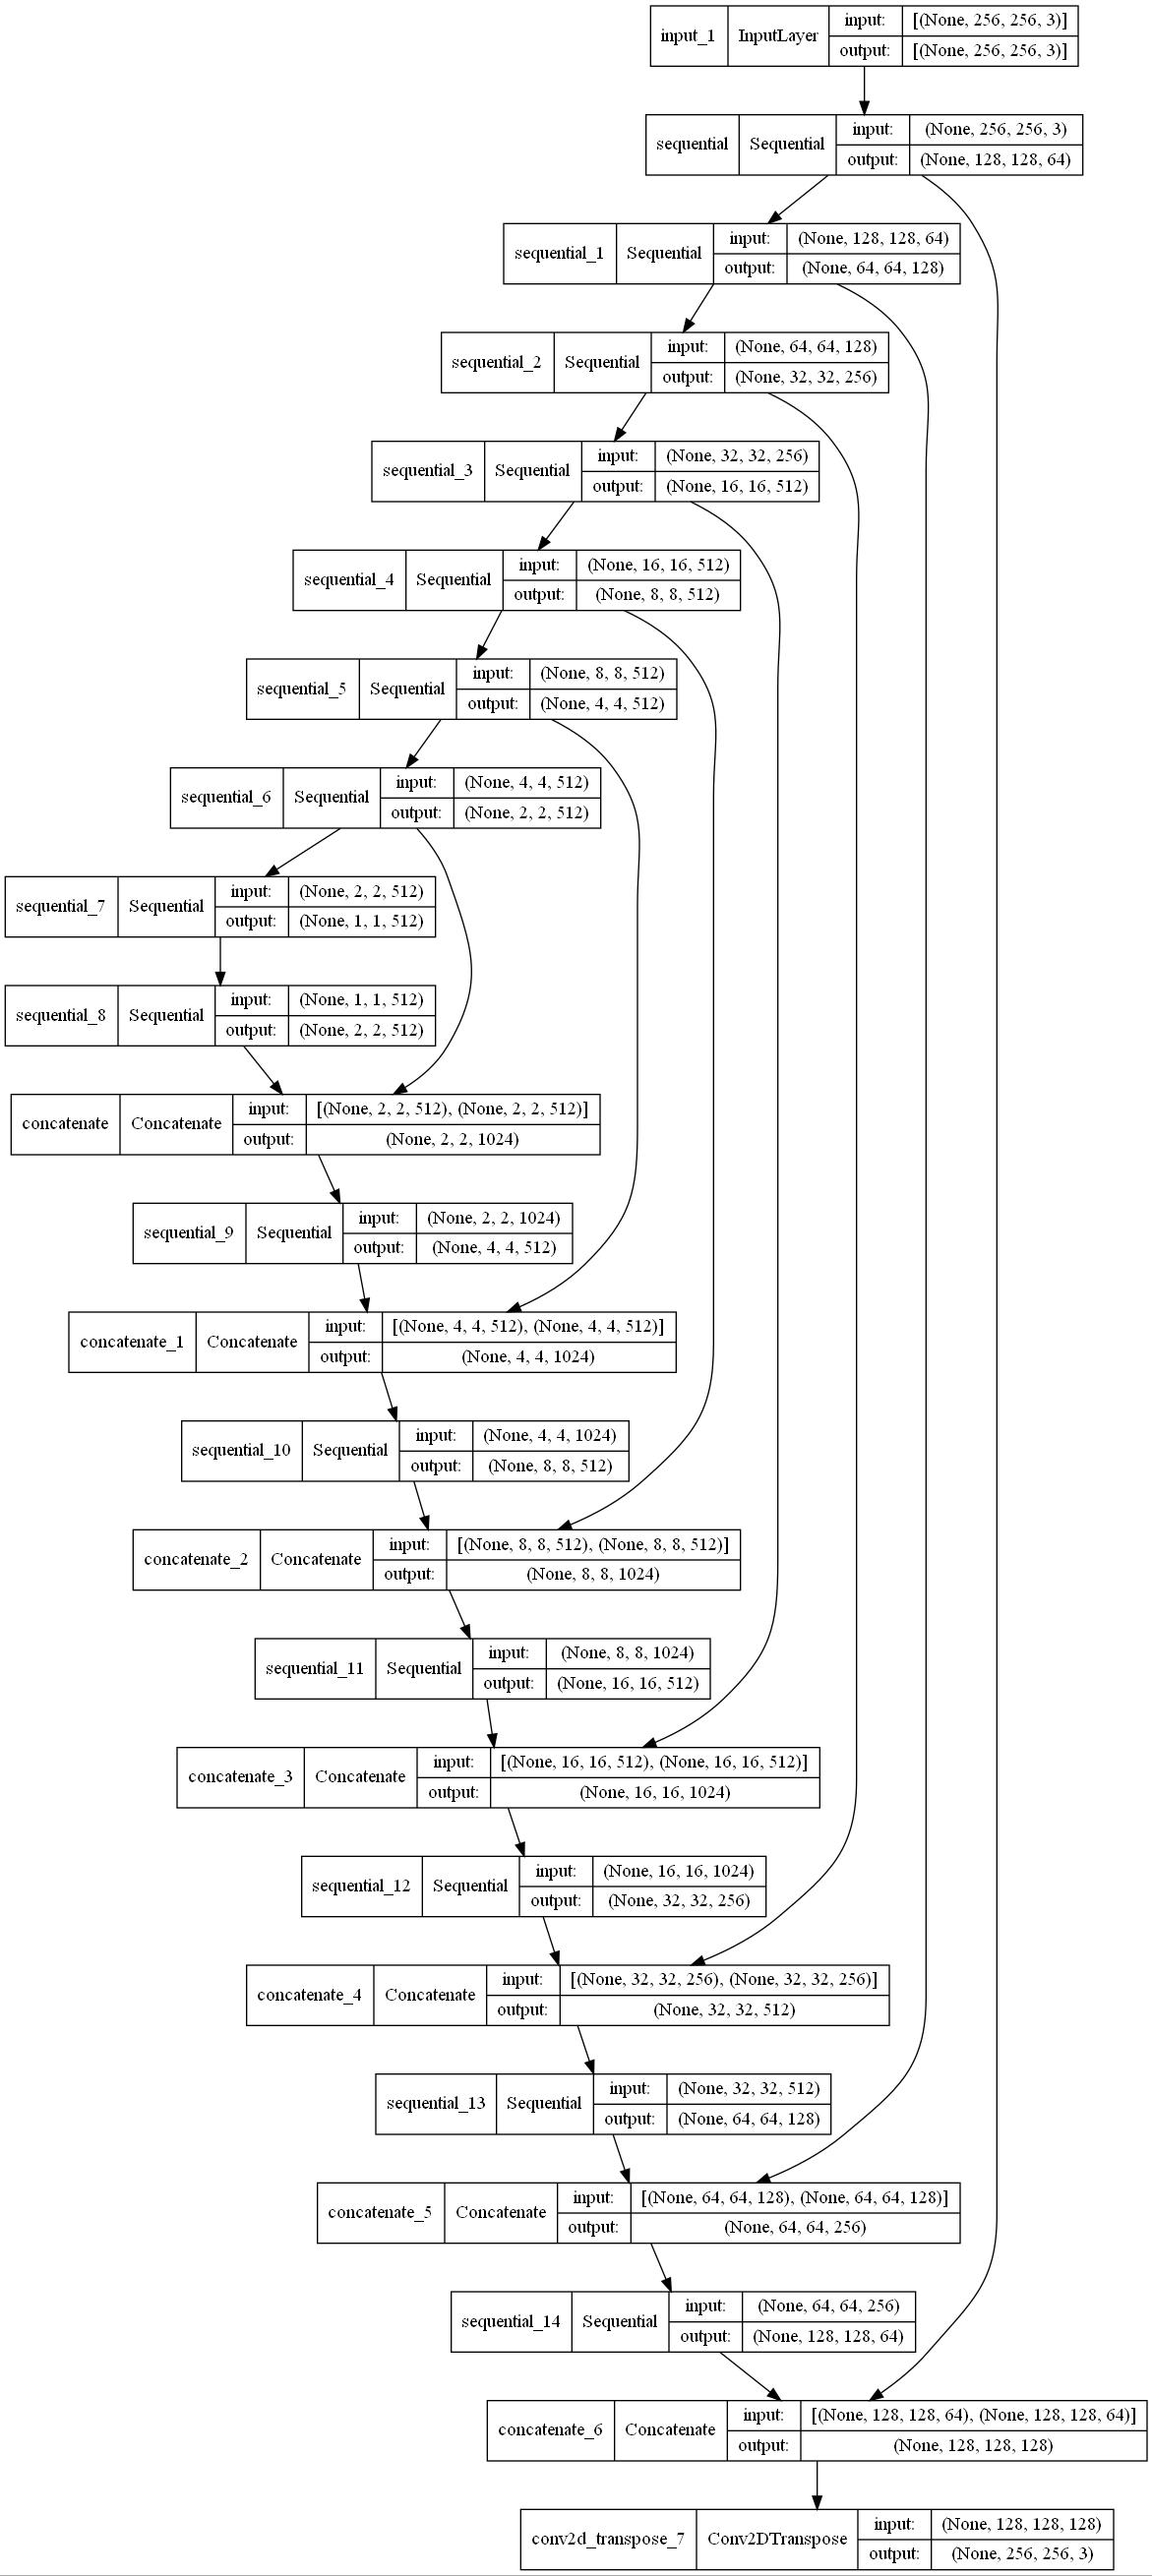

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(pix2pix.generator, show_shapes=True, show_layer_names=True, to_file='pix2pix_generator_cityscapes.jpg')

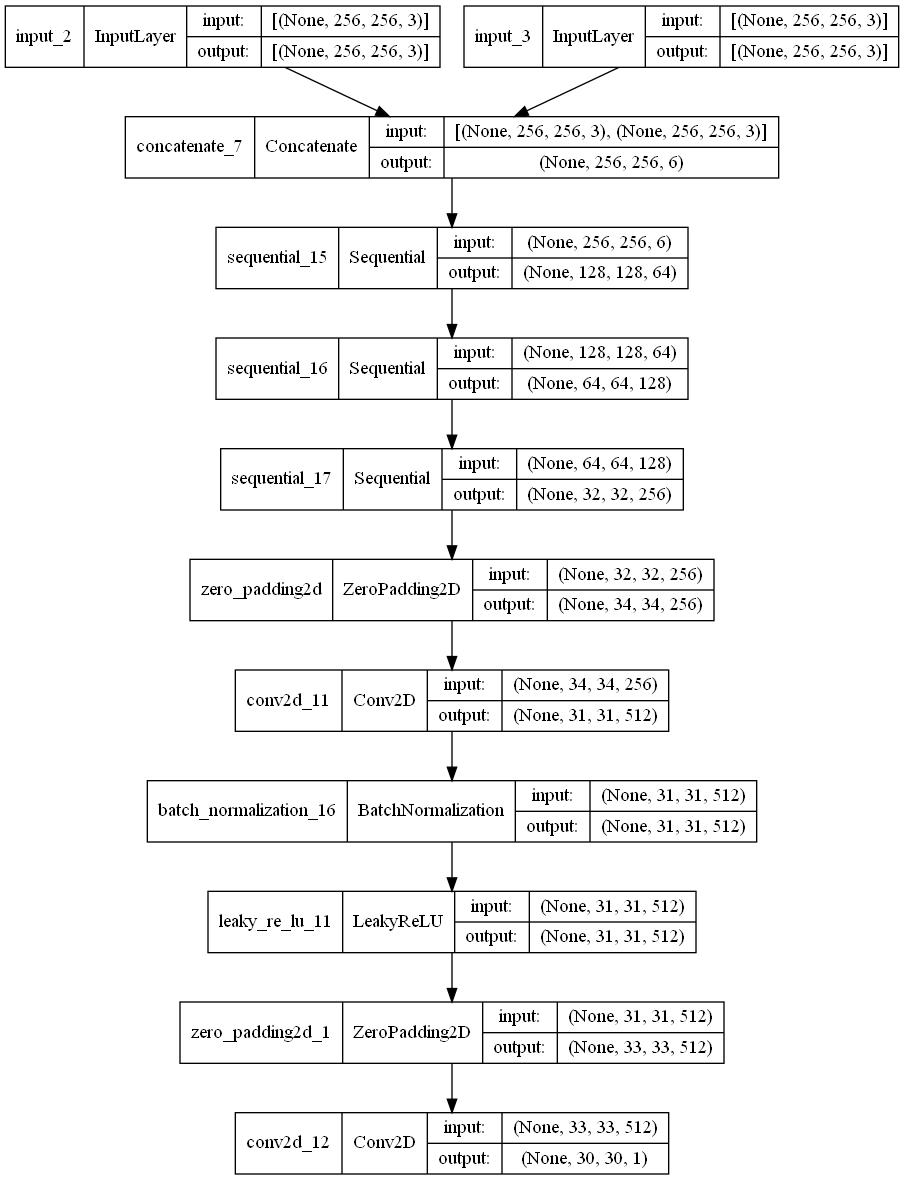

In [17]:
plot_model(pix2pix.discriminator, show_shapes=True, show_layer_names=True, to_file='pix2pix_discriminator_cityscapes.jpg')